<h2 style="text-align: center;">НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ 
<br/>МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ</h2>
</br>
<h3 style="text-align: center;">Кафедра Паровых и Газовых Турбин</h3>

</br>
</br>
</br>
</br>
</br>

<h1 style="text-align: center;">Курсовая работа по курсу:</h1>
<h1 style="text-align: center;">«Паровые и газовые турбины»</h1>

</br>
</br>
</br>
</br>
</br>

<h5 style="text-align: right;">Студент: Бонадыков Никита Михайлович</h5>
<h5 style="text-align: right;">Группа: ТФэ-01-20</h5>

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

<h5 style="text-align: center;">Москва 2023</h5>

# 1.1 Исходные данные
### Вариант №2

## $\space$ Дано:
* $P_0 = 24 \space МПа $ - Начальное давление
* $t_0 = 555 ^\circ C$ -  Начальная температура
* $P_{пп} = 3.66 \space МПа$ -  Давление промперегрева 
* $t_{пп} = 552 ^\circ C$ -  Температура промперегрева
* $P_{к} = 3.4 \space кПа$ -  Давление в конденсаторе
* $t_{п.в.} = 271^\circ C$ -  Температура питательной воды
* $N_{э} = 840 \space МВт$ -  Электрическая мощность
* $z = 9 \space шт$  Число регенеративных подогревателей
* $d_{р.с.} = 1.2 \space м$  Средний диаметр
* $n = 60 \space C ^{-1}$  Частота вращения ротора турбины
* $H_{0} = (90-110) \space кДж/кг$ -  Располaгаемый теплоперепад
* $\eta_{oi} = 85  \space % $ КПД цилиндров турбины
* $\eta_{мех} = 85  \space % $ Механический КПД турбины
* $\eta_{эг} = 85  \space % $ КПД электрического генератора


In [1]:
#Импорт библиотек
import iapws
from iapws import IAPWS97 as gas
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd 
import Inner_part

In [2]:
#Инициализация всомагательных параметров расчета  
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [3]:
#Дано
electrical_power = 840 * (10 ** 6) # Электрическая мощность    
p0 = 24 * MPa # Начальное давление 
t0 = 555 # Начальная температура 
pk = 3.4 * kPa # Давление в конденсаторе
p_middle = 3.4 * MPa # Давление промперегрева
t_middle = 552 # Температура промперегрева 
p_feed_water = 1.4 * p0 # Давление питательной воды 
t_feed_water = 271 # Температура питательной воды
z = 8 # Число регенеративных подогревателей
internal_efficiency = 0.85 # КПД цилиндров турбины
mechanical_efficiency = 0.992 # Механический КПД турбины
generator_efficiency = 0.99 #КПД электрического генератора
d_sr = 1.2 # Средний диаметр 
n = 60 # Частота вращения ротара турбины 
H0 = np.arange(80,120) # Распологаемый теплоперепад 
p = 0.05 # Степень реактивности 


# 1.2 Определение расходов пара на входе в турбиину $(G_{0})$ и в конденсатор $(G_{k})$ для турбины с промперегревом

In [4]:
inlet_mass_flow = Inner_part.complite_inlet_mass_flow(p0, t0, p_middle, t_middle, pk, p_feed_water, 
                t_feed_water, internal_efficiency, mechanical_efficiency, generator_efficiency, electrical_power, z)
condenser_mass_flow = Inner_part.complite_condenser_mass_flow(p0, t0, p_middle, t_middle, pk, 
                    p_feed_water, t_feed_water, internal_efficiency, mechanical_efficiency, generator_efficiency, 
                    electrical_power, z)  
Inner_part.tab_flow(p0, t0, p_middle, t_middle, pk, p_feed_water, t_feed_water, internal_efficiency, 
                    mechanical_efficiency, generator_efficiency, electrical_power, z)

,,
Показатель,Массовый расход в турбину на входе,Массовый расход в конденсатор
Параметры,$G_{0}$,$G_{k}$
Значение,660.79696,436.723709


# 1.3 Построение h-s диаграммы процесса

In [5]:
point0,point1,point2,point_middle = Inner_part.point_s(p0,t0,p_middle,t_middle,pk,internal_efficiency)       
Inner_part.tab_point(p0,t0,p_middle,t_middle,pk,internal_efficiency)

,point 0,point 1,point middle,point 2
"P, МПа",22.800000,3.740000,3.298000,0.003400
"T, K",823.798877,564.592646,824.731592,299.331624
"h, $\frac{кДж}{кг}$",3366.687307,2946.639584,3570.391748,2393.901027
"S, $\frac{кДж}{кг * K}$",6.250893,6.365060,7.334731,8.014553


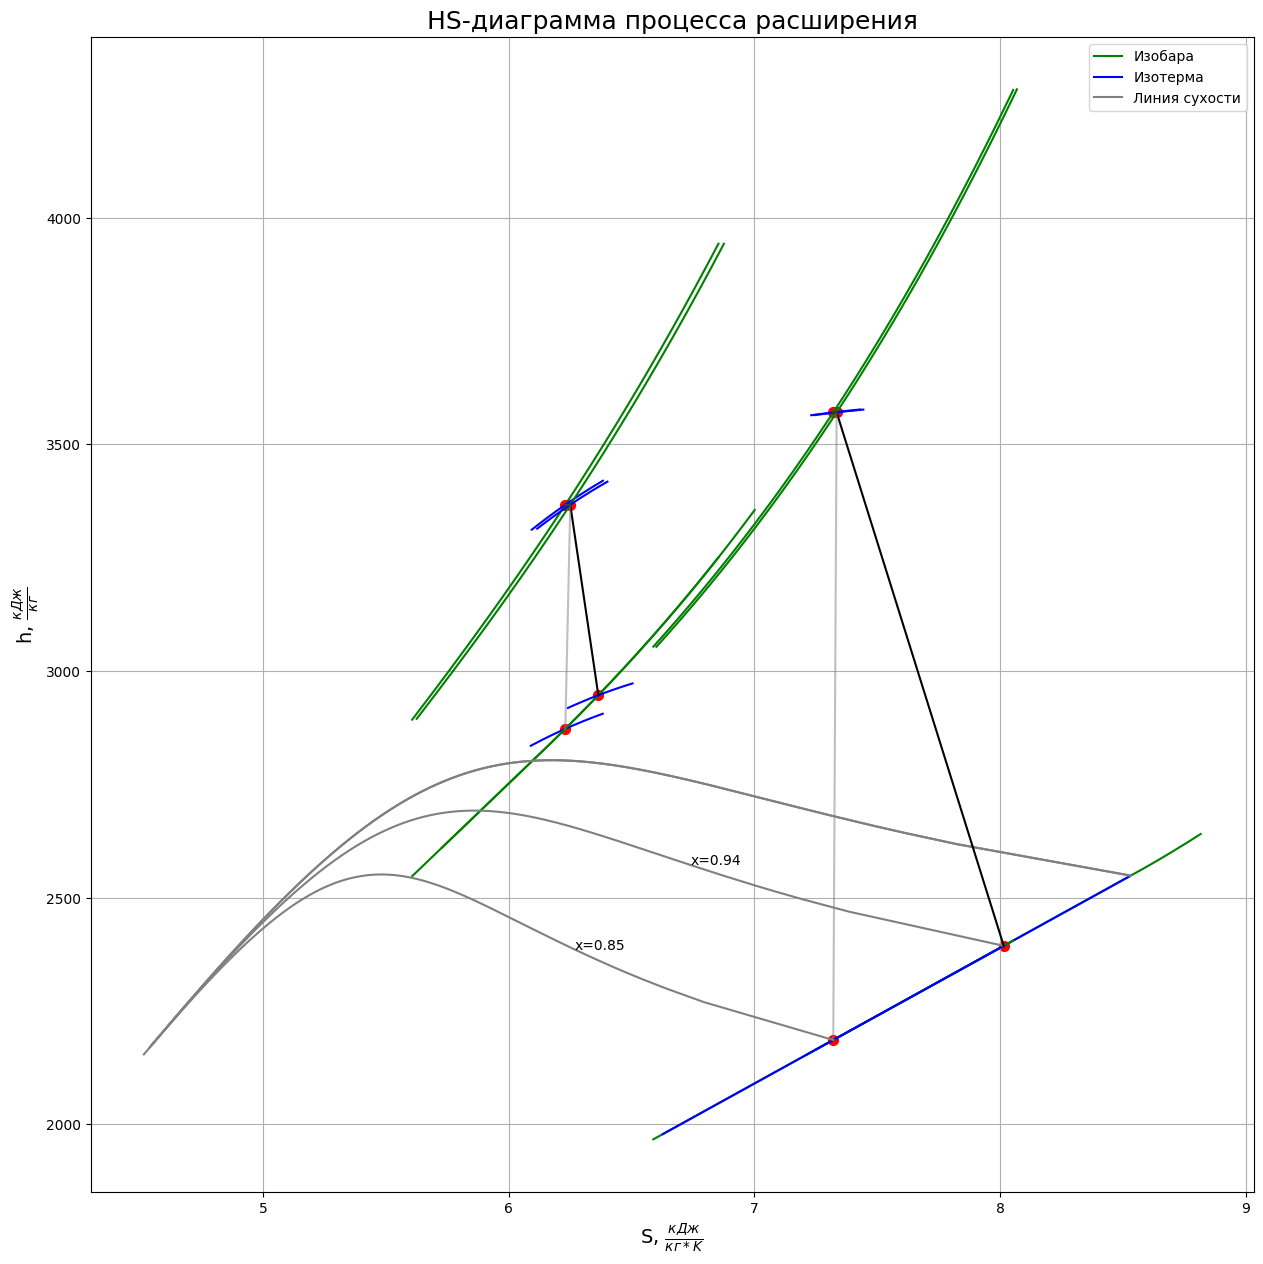

In [6]:
Inner_part.plot_hs(p0, t0, p_middle, t_middle, pk, internal_efficiency)

# 2.1 Зависимость КПД от $\frac{U}{cф}$

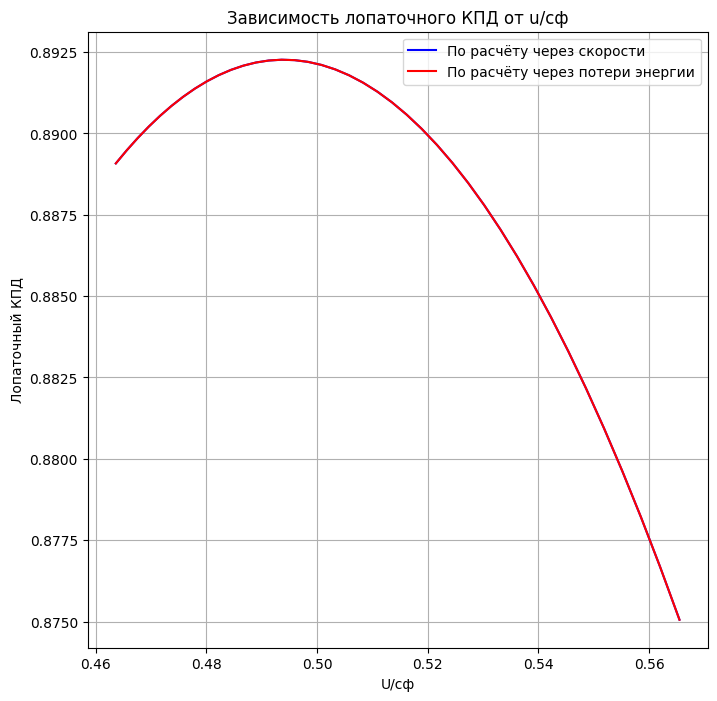

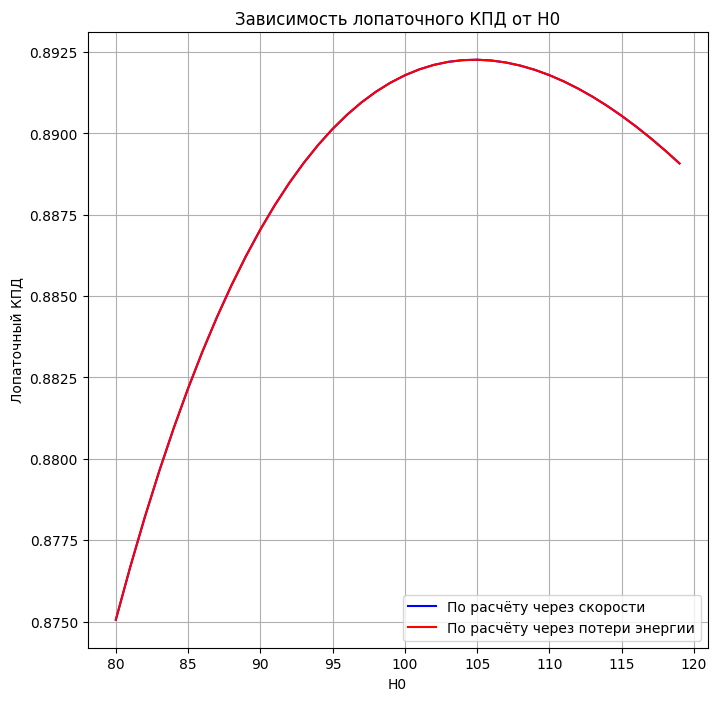

In [7]:
Inner_part.efficiency_graph(point0, d_sr, n, p, H0, inlet_mass_flow)

 ##### Исходя из графиков, можно сделать вывод, что $H_{0}$ оптимальное при значении 105 $\frac{кДж}{кг}$

# 2.2 Построение процесса расширения в регулирующей ступени

In [8]:
Inner_part.tab_point_reg(point0, d_sr, n, p, 105, inlet_mass_flow)

,point 0,point 1,point 2,point konec
"P, МПа",24.000000,17.452560,17.152210,17.152210
"T, K",828.150000,771.199556,769.075126,771.349127
"h, $\frac{кДж}{кг}$",3366.687307,3271.326307,3269.009717,3275.997585
"S, $\frac{кДж}{кг * K}$",6.230735,6.236431,6.240248,6.249321


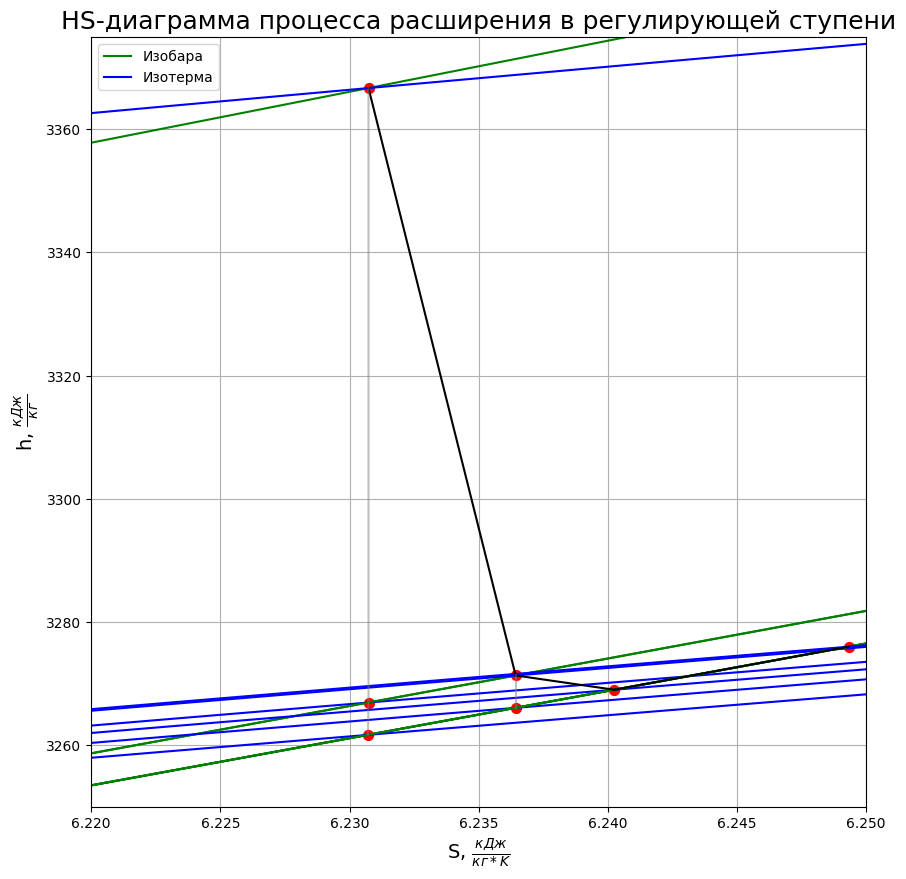

In [9]:
Inner_part.plot_reg(point0, d_sr, n, p, 105, inlet_mass_flow)

# 2.3 Треугольник скоростей при оптимальном значении $H_{0}$

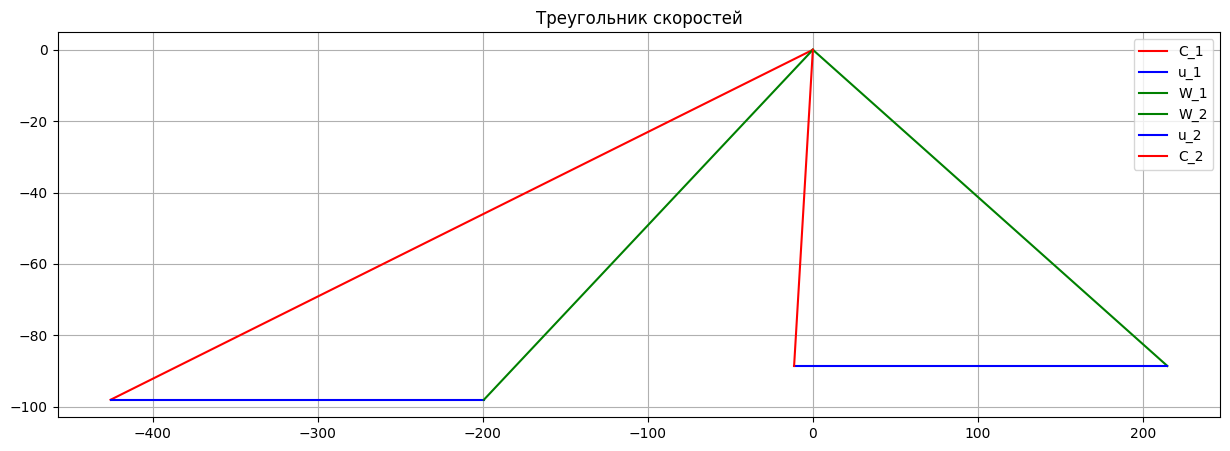

In [10]:
Inner_part.plot_triangles(point0, d_sr, n, p, 105, inlet_mass_flow)

# 2.5 Расчет Параметров при оптимальном теплоперепаде 

In [11]:
Inner_part.data_output(point0, d_sr, n, p, 105, inlet_mass_flow)
Inner_part.data_output1(point0, d_sr, n, p, 105, inlet_mass_flow)

Предрасчет сопловой решетки


,Показатель,Параметр,Значение
0,Теплоперепад в сопловой решётке,$H_{0c} \space \frac{кДж}{кг}$,99.800
1,Теплоперепад в рабочей решётке,$H_{0p} \space \frac{кДж}{кг}$,5.200
2,Распалагаемый теплоперепад,$H_{0} \space \frac{кДж}{кг}$,105.000
3,Теоретическая абсолютная скорость на выходе из...,"$c_{1t}, \space \frac{м}{с}$",446.654
4,Скорость звука на выходе из сопловой решётки,"$a_{1t}, \space \frac{м}{с}$",650.240
5,Число Маха на выходе из сопловой решётки,$M_{1t}$,0.687
6,Предварительная площадь выхода потока из сопло...,"$F_{1}, \space м^{2}$",0.026
7,Стерень реактивности,$\rho$,0.050


Расчет дополнительных параметров сопловой решетки


,Показатель,Параметр,Значение
0,Произведение el1,"$el_{1}, м$",0.031122
1,Оптимальное значение степени парциальности,$e_{opt}$,0.705656
2,"Высота сопловых лопаток, мм","$l_{1}$, м",0.044103
3,"Хорда сопловой решётки, мм","$b_{1}$, м",52.500000
4,Уточняем коэффициент расхода сопловой решетки,$\mu_{1}$,0.976048
5,Количество лопаток в сопловой решетке,$z_{1}$,64.000000
6,Уточненый оптимальный относительный шаг,$t_{1}$,0.791744


Расчет параметров сопловой решетки из аталаса


,Показатель,Параметр,Значение
0,Угол установки профиля решётки,"$\alpha_{уст}, град$",33.200000
1,Отношение: b1/l1,$\frac{b_{1}}{l_{1}}$,1.190000
2,Коэффициент профильных потерь,$\xi_{проф}$,2.000000
3,Коэффициент суммарных потерь,$\xi_{сум}$,4.400000
4,Коэффициент концевых потерь,$\xi_{конц}$,2.400000
5,Коэффициент скорости сопловой решетки,$\phi$,0.977753
6,Скорость выхода пара из сопловой решетки,$c_{1} \frac{м}{с}$,436.717300
7,Угол выхода потока из сопловой решётки,"$\alpha_{1}, град$",12.976942


Предрасчет рабочей решетки


,Показатель,Параметр,Значение
0,Относительная скорость на выходе из сопловой р...,$w_{1} \space \frac{м}{с}$,222.183523
1,Угол направления относительной скорости потока...,"$\beta_{1}, град$",26.192366
2,Теоретическая относительная скорость на выходе...,"$w_{2t}, \space \frac{м}{с}$",244.674310
3,Высота рабочих лопаток,"$l_{2}, м$",0.048103
4,"Хорда решётки, мм","$b_{2}, м$",45.000000
5,Скорость звука за рабочей решеткой (теоретичес...,"$a_{2t}, \space \frac{м}{с}$",626.417630
6,Теоретическое число Маха за рабочей решёткой,$M_{2t}$,0.390593
7,Потери в сопловой решетке,$\Delta H_{c} \frac{кДж}{кг}$,4.389000


Расчет дополнительных параметров рабочей решетки


,Показатель,Параметр,Значение
0,Коэффициент расхода рабочей решётки,$\mu_{2}$,0.955645
1,Выходная площадь рабочей решётки,$F_{2} \space м^{2}$,0.049733
2,Эффективный угол выхода потока из рабочей решётки,"$\beta_{2e}, град$",22.267418
3,Количество лопаток в рабочей решётке,$z_{2}$,125.000000
4,Оптимальный шаг рабочей решётки,$t_{2opt}$,0.675000
5,Угол установки рабочих лопаток,"$\beta_{уст}, град$",86.148668
6,Отношение $\frac{b_{2}}{l_{2}}$,$\frac{b_{2}}{l_{2}}$,0.935483


Расчет параметров рабочей решетки из аталаса


,Показатель,Параметр,Значение
0,Коэффициент профильных потерь в решётке,$\xi_{проф}$,5.500000
1,Коэффициент суммарных потерь,$\xi_{сум}$,9.800000
2,Коэффициент концевых потерь,$\xi_{конц}$,4.300000
3,Коэффициент скорости рабочей решётки,$\psi$,0.949737
4,Угол направления относительной скорости на вых...,"$\beta_{2}, град$",22.413444
5,Абсолютная скорость на выходе из рабочей решётки,"$c_{2}, \space \frac{м}{с}$",89.329030
6,Угол выхода абсолютной скорости из рабочей реш...,"$\alpha_{2}, град$",97.314489
7,Действительная относительная скорость на выход...,"$w_{2}, \space \frac{м}{с}$",232.376197


,Показатель,Параметр,Значение
0,Потери в рабочей решетки,$\Delta H_{р} \frac{кДж}{кг}$,2.930
1,Энергия выходной скорости,$\Delta H_{vc} \frac{кДж}{кг}$,3.990
2,Располагаемая энегрия ступени,$E_{0}\frac{кДж}{кг}$,105.000
3,Внутренний относительный кпд ступени,$\eta_{oi}$,0.822
4,Относительный лопаточный КПД,$\eta_{о.д}$,0.892
5,Внутренния мощность ступени,"$N_{oi}$, кВт",57027.300


# 3. Определение числа ступеней и распределение параметров по ним

Корневой диаметр =  0.9431588539197701 м


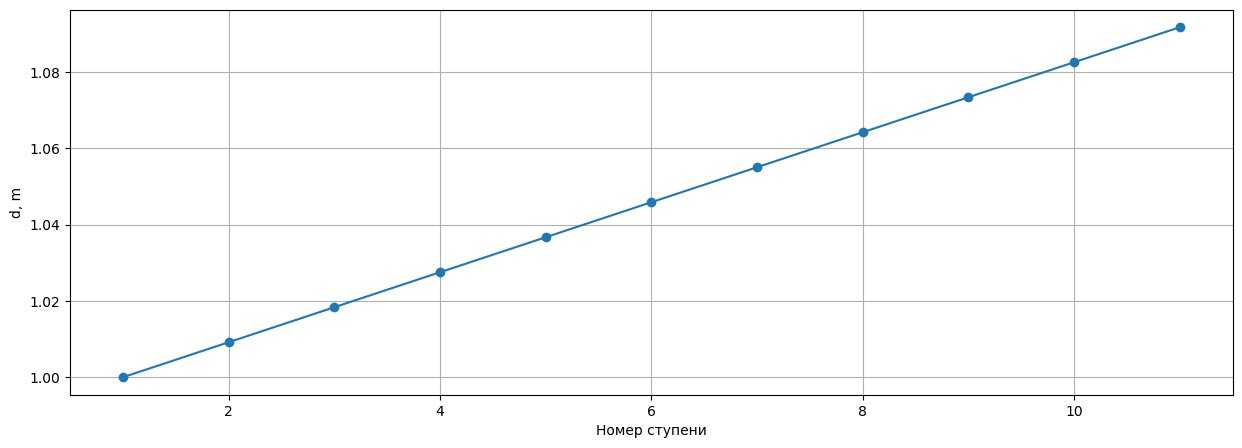

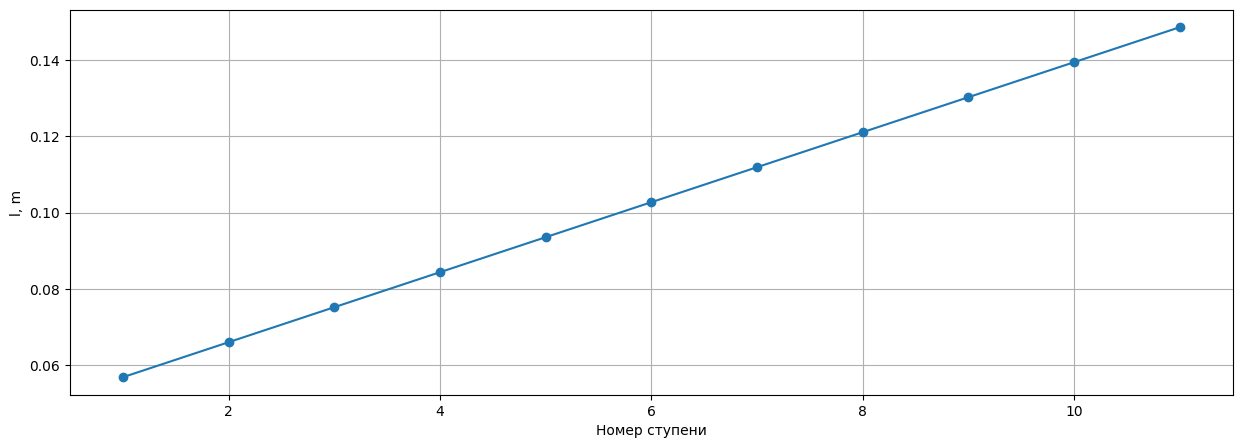

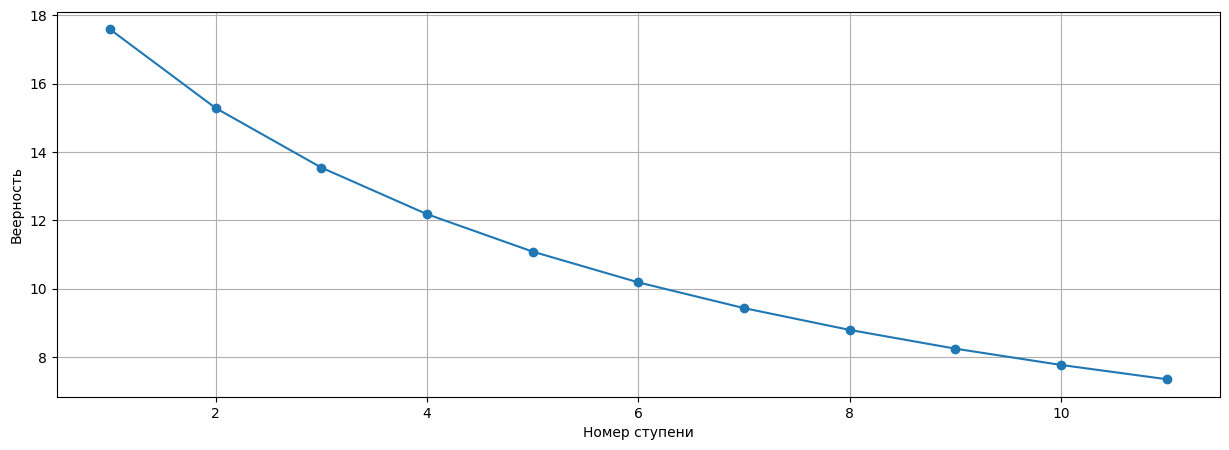

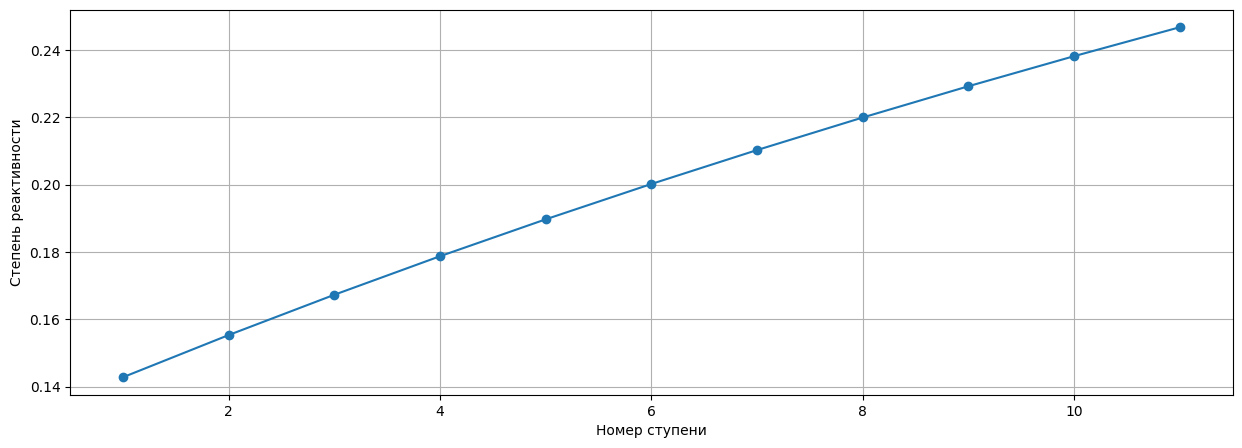

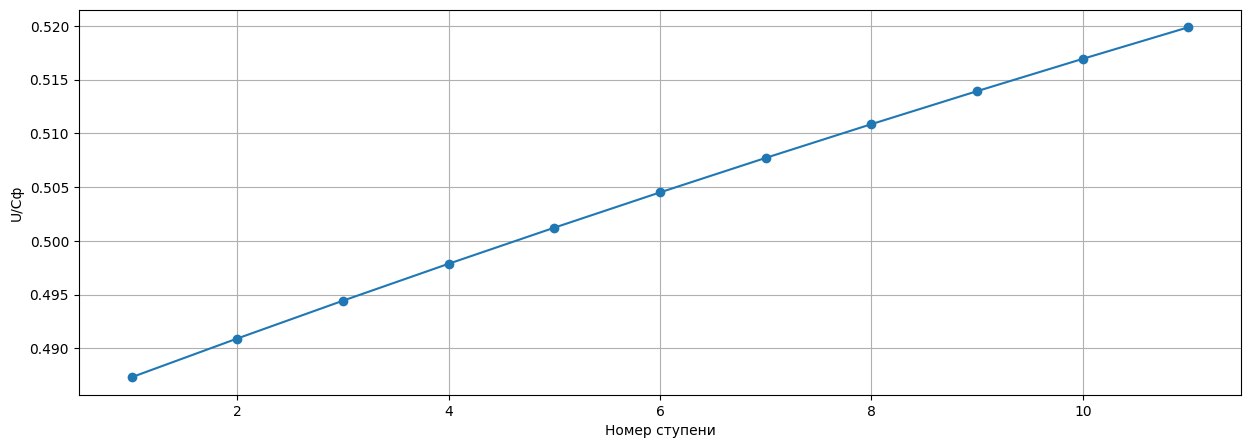

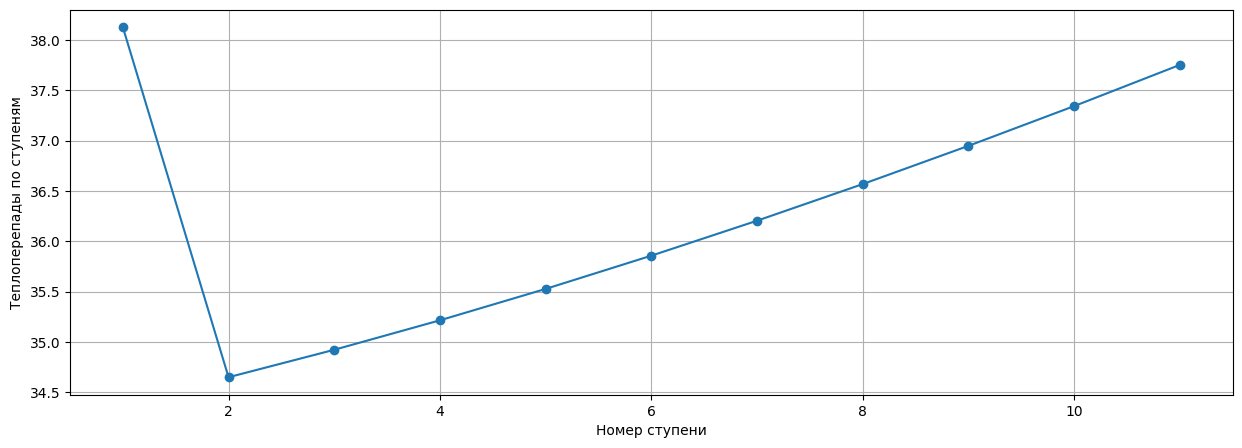

In [12]:
veernost_1 = 18.7
n_stages = 11
Inner_part.root_diameter_print(point0, d_sr, n, p, 105, inlet_mass_flow, internal_efficiency,n_stages,veernost_1)
Inner_part.plot_heat_drop(point0, d_sr, n, p, 105, inlet_mass_flow, internal_efficiency,n_stages,veernost_1)

# 4.1 Определение собственных колебаний

404.9056846762794 2914.868345523192 2042.0486007051338


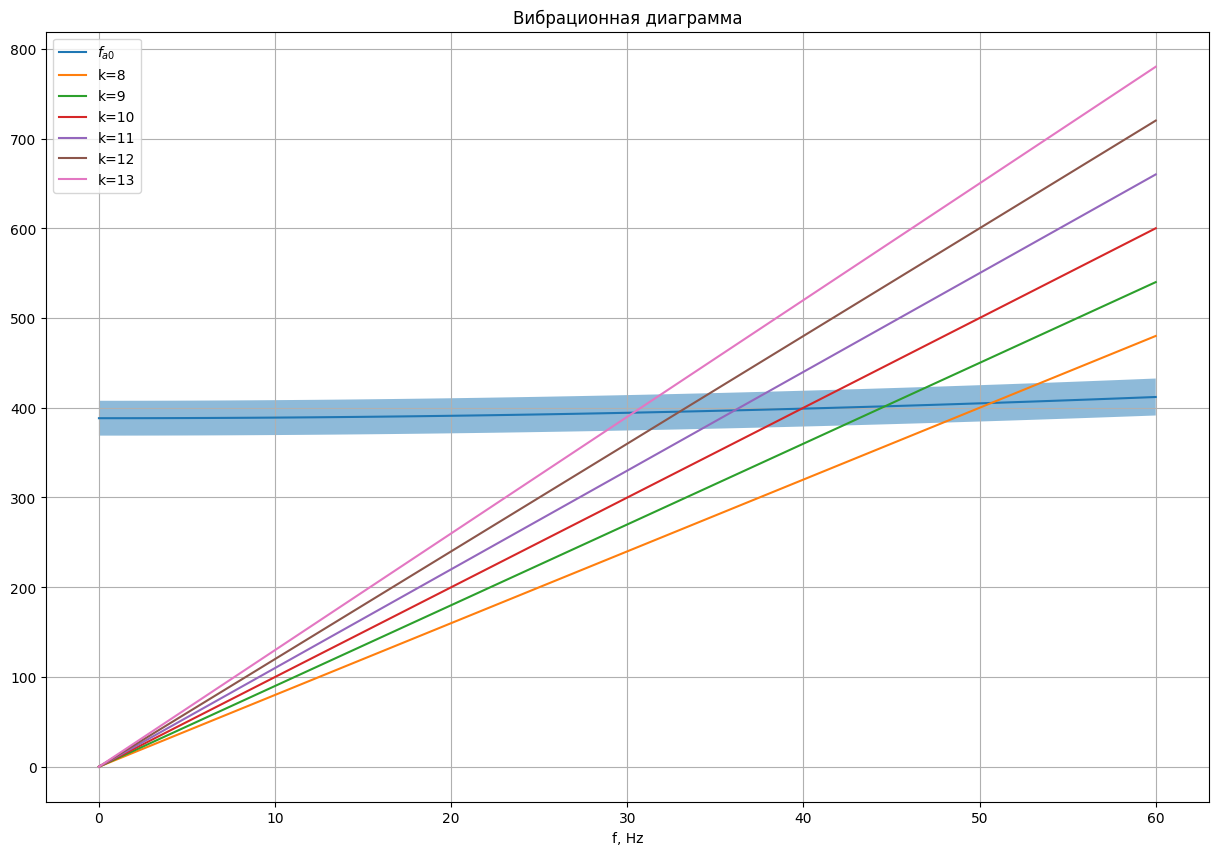

In [13]:
Inner_part.vibra(point0, d_sr, n, p, 105, inlet_mass_flow, internal_efficiency,n_stages,veernost_1)

# 4.2 Определение критических частот вращения ротора ЦВД турбины


In [14]:
Inner_part.kritic_rot_speed()

Средняя изгибная жесткость ротора 868065875.4043777
Первая собственная частота вращения ротора по первому тону колебаний на абсолютно жестких опорах 348.8687697872316 rad/s
Первая собственная частота вращения ротора по второму тону колебаний на абсолютно жестких опорах 1395.4750791489264 rad/s
2-e собственные частоты вращения ротора на упругих опорах 258.83597891568536 rad/s
2-e собственные частоты вращения ротора на упругих опорах 407.5609693716306 rad/s
Первая критическая частота вращения ротора 207.8712746416942 rad/s 33.08374088603859 Гц
Вторая критическая частота вращения ротора 391.2172541145381 rad/s 62.26415981516687 Гц


# 5. Проверка рабочих лопаток на прочность

In [15]:
Inner_part.data_output3(point0, d_sr, n, p, 105, inlet_mass_flow)

,Показатель,Параметр,Значение
0,Момент сопротивления профиля рабочей лопатки,$W2_{min}$,2.045516e+00
1,Напряжение изгиба лопатки,$\sigma$,3.648457e+01
2,угловая скорость рабочего колеса,$\omega$,3.769911e+02
3,Напряжение растяжения лопатки,$\sigma$,3.199518e+07


In [16]:
Inner_part.dstrength(point0, d_sr, n, p, 105, inlet_mass_flow, internal_efficiency,n_stages,veernost_1)

Коэффициент запаса прочности:  2.528597100051189
